### "Telco-Customer-Churn" data refers to an analysis of customers leaving a telecommunications company. The goal is to predict and understand the reasons why customers abandon services such as telephone, multiple lines, internet

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [9]:
df=pd.read_csv("dataset/customer_behaviour.csv")
pd.set_option('display.max_columns', None)
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


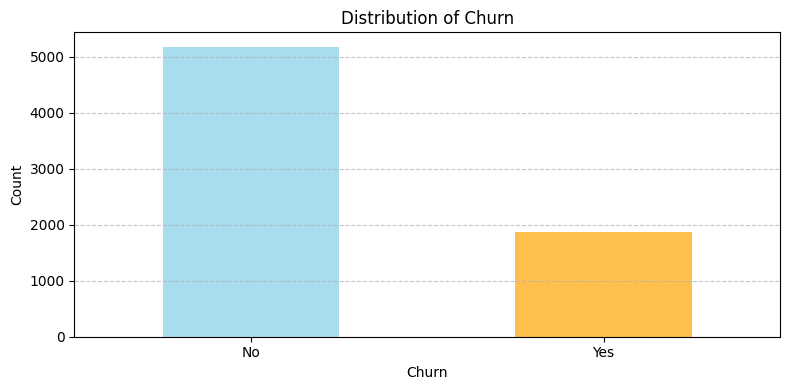

In [11]:
def distribution_plot(df, col):
    plt.figure(figsize=(8, 4))
    df[col].value_counts().plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

distribution_plot(df, col="Churn")


## 1️⃣ Preprocessing Data

In [12]:
class EncodeCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, handle_unknown='use_encoded_value', unknown_value=-1):
        """
        Uses OrdinalEncoder to encode categorical features.
        This transformer is designed to be used in a pipeline.
        fit() will find the categorical columns in the DataFrame.
        transform() will apply the encoding to these columns.
        """
        
        self.encoder = OrdinalEncoder(handle_unknown=handle_unknown, unknown_value=unknown_value)
        self.cat_cols = None

    def fit(self, df, y=None):
        self.cat_cols = df.select_dtypes(include=['object']).columns
        if len(self.cat_cols) > 0:
            self.encoder.fit(df[self.cat_cols])
        return self

    def transform(self, df):
        df_copy = df.copy()
        if len(self.cat_cols) > 0:
            df_copy[self.cat_cols] = self.encoder.transform(df_copy[self.cat_cols])
        return df_copy

## OrdinalEncoder

1. **Encode multiple columns at once**

2. **Pipeline-friendly** and compatible with sklearn transformers like ColumnTransformer and Pipeline.

In [13]:
class CorrelationFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selects features based on correlation with a target variable.
    This transformer is designed to be used in a pipeline.
    threshold: float, default=0.1
        The absolute correlation value above which features are selected.
    """
    def __init__(self, target_col, threshold=0.1, preserve_target=True, exclude_cols=None):
        self.target_col = target_col
        self.threshold = threshold
        self.preserve_target = preserve_target
        self.exclude_cols = exclude_cols or []
       
        if isinstance(self.exclude_cols, str):
            self.exclude_cols = [self.exclude_cols]

    def fit(self, X, y=None):
        df = X.copy()

        corr_matrix = df.corr()
        
        # Select features with correlation above threshold
        self.relevant_features = corr_matrix[self.target_col][
            corr_matrix[self.target_col].abs() > self.threshold
        ].index.tolist()
   
        if self.target_col in self.relevant_features:
            self.relevant_features.remove(self.target_col)
        
        for col in self.exclude_cols:
            if col in self.relevant_features:
                self.relevant_features.remove(col)
        
        # Add target column if preserve_target is True
        if self.preserve_target and self.target_col in df.columns:
            self.relevant_features.append(self.target_col)
            
        return self

    def transform(self, X):
        return X[self.relevant_features]

In [14]:
class CustomBalancerSMOTE(BaseEstimator, TransformerMixin):
    """
    Balances the dataset using SMOTE (Synthetic Minority Over-sampling Technique).
    This transformer is designed to be used in a pipeline.
    desired_ratio: float, default=0.4 expected proportion of the minority class in the resampled dataset.
    random_state: int, default=42 
    fit()
    """
    def __init__(self, target_col='Churn', desired_ratio=0.4, random_state=42):
        self.target_col = target_col
        self.desired_ratio = desired_ratio
        self.random_state = random_state

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        
        if self.target_col not in df.columns:
            raise ValueError(f"Target column '{self.target_col}' not found in the dataframe")
            
        X_features = df.drop(columns=[self.target_col])
        y_target = df[self.target_col]

        if y_target.dtype == 'object':
            y_target = y_target.map({'No': 0, 'Yes': 1})

        smote = SMOTE(sampling_strategy=self.desired_ratio / (1 - self.desired_ratio), random_state=self.random_state)
        X_resampled, y_resampled = smote.fit_resample(X_features, y_target)

        if y_target.dtype == 'object':
            y_resampled = pd.Series(y_resampled).map({0: 'No', 1: 'Yes'})
        else:
            y_resampled = pd.Series(y_resampled)
            
        df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X_features.columns), 
                                 y_resampled.rename(self.target_col)], axis=1)

        return df_resampled

## Split data into for training and testing

In [15]:
X = df.copy()
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
# Pipline gives clear steps of how model was trained
pipeline = Pipeline([
    ('encode', EncodeCategorical()),
    ('balance', CustomBalancerSMOTE(target_col='Churn', desired_ratio=0.4)),
    ('feature_select', CorrelationFeatureSelector(target_col='Churn', threshold=0.1)),
])

In [17]:
# Transform the training data
transformed_train = pipeline.fit_transform(X_train)
X_train_transformed = transformed_train.drop(columns=['Churn'])
y_train_transformed = transformed_train['Churn']

In [18]:
# Transform the test data (using the fitted pipeline)
transformed_test = pipeline.transform(X_test)
X_test_transformed = transformed_test.drop(columns=['Churn'])
y_test_transformed = transformed_test['Churn']

d:\Sigmoid_Intership\Sigmoid_Homework\.venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [19]:
#Three types of Naive Bayes classifiers
gaussian_nb = GaussianNB()
multinomial_nb = MultinomialNB()
bernoulli_nb = BernoulliNB()

## Gaussian Naive Bayes

In [20]:
gaussian_nb.fit(X_train_transformed, y_train_transformed)
gaussian_pred = gaussian_nb.predict(X_test_transformed)

## Multinomial Naive Bayes

In [ ]:
#Because MultinomialNB requires non-negative values, we need to check for negative values in the transformed data and handle them 
has_negative = (X_train_transformed < 0).any().any()
if has_negative:
    print("Warning: Multinomial NB requires non-negative values. Converting negative values to 0.")
    X_train_transformed_mnb = X_train_transformed.copy()
    X_test_transformed_mnb = X_test_transformed.copy()
    # Replace negative values with 0 for Multinomial NB in the transformed data
    X_train_transformed_mnb[X_train_transformed_mnb < 0] = 0
    X_test_transformed_mnb[X_test_transformed_mnb < 0] = 0
    multinomial_nb.fit(X_train_transformed_mnb, y_train_transformed)
    multinomial_pred = multinomial_nb.predict(X_test_transformed_mnb)
else:
    multinomial_nb.fit(X_train_transformed, y_train_transformed)
    multinomial_pred = multinomial_nb.predict(X_test_transformed)

## Bernoulli

In [22]:
X_train_transformed_bnb = X_train_transformed.copy()
X_test_transformed_bnb = X_test_transformed.copy()

# If data is not all 0s and 1s, binarize it,in my case my data permit this to do 
if not ((X_train_transformed_bnb.isin([0, 1])).all().all()):
    print("Converting features to binary for Bernoulli NB")
    # Simple binarization: values > 0 become 1, otherwise 0
    X_train_transformed_bnb = (X_train_transformed_bnb > 0).astype(int)
    X_test_transformed_bnb = (X_test_transformed_bnb > 0).astype(int)

bernoulli_nb.fit(X_train_transformed_bnb, y_train_transformed)
bernoulli_pred = bernoulli_nb.predict(X_test_transformed_bnb)


Converting features to binary for Bernoulli NB


In [ ]:
import pandas as pd
from IPython.display import display

gaussian_accuracy = accuracy_score(y_test_transformed, gaussian_pred)
multinomial_accuracy = accuracy_score(y_test_transformed, multinomial_pred)
bernoulli_accuracy = accuracy_score(y_test_transformed, bernoulli_pred)

accuracy_data = {
    'ML Model': ['Gaussian Naive Bayes', 'Multinomial Naive Bayes', 'Bernoulli Naive Bayes'],
    'Accuracy': [
        f"{gaussian_accuracy:.4f}", 
        f"{multinomial_accuracy:.4f}", 
        f"{bernoulli_accuracy:.4f}"
    ]
}

df_results = pd.DataFrame(accuracy_data)

# If code in Jupyter notebook, you can style the table to look more like the image
if 'get_ipython' in globals():
    styled_table = df_results.style.set_table_attributes('border="1" class="dataframe"')
    display(styled_table)
else:
    # For python files, just print the DataFrame
    print("\nModel Accuracy Results:")
    print(df_results.to_string(index=False))

,ML Model,Accuracy
0,Gaussian Naive Bayes,0.7421
1,Multinomial Naive Bayes,0.7386
2,Bernoulli Naive Bayes,0.7057


## **Conclusion**

After getting these results I found rules when and in what case to use each algorithm: 

***Gaussian NB*** typically works better for continuous data, 

***Multinomial NB*** for count data,but also it was a good option in my case, and 

***Bernoulli NB*** for binary data. My dataset appears to contain information that is best preserved in its continuous form.

This is the main reason why accuracy score for Gaussian and Bernoulli differ a little bit.